In [1]:
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import (about, basis, destroy, hinton, ptrace, qdiags, qeye, steadystate, sigmam, sigmaz, Options,
                   projection, parallel_map, expect, tensor, wigner, wigner_cmap)
import latex
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
# Parameters
kappa = 1.0 #cavity mode dissipation rate (this is why the parameters should be passed as arguments to the function func1)
Oc = 1.0*kappa #Rabi frequency 
delta = kappa   # Delta_P
Nat = 1    
N = 6 #Fock space dimension
g = 1 #/np.sqrt(Nat))*kappa # List atom-field coupling strenght
EM = np.sqrt(0.01)*kappa #pump field strength
norm = 4*(EM/(kappa))**2 #normalization
#decay rates
G31 = 0.5*kappa  #atom
G32 = 0.5*kappa  #atom
#detunings
D1 = 0.0
D2 = 0.0
#D2 = kappa

#Operators
a = tensor(destroy(N), qeye(3))
sm = tensor(qeye(N), sigmam())
sz = tensor(qeye(N), sigmaz())
S11 = tensor(qeye(N), basis(3,0) * basis(3,0).dag())
S22 = tensor(qeye(N), basis(3,1) * basis(3,1).dag())
S33 = tensor(qeye(N), basis(3,2) * basis(3,2).dag())
S13 = tensor(qeye(N), basis(3,0) * basis(3,2).dag())
S23 = tensor(qeye(N), basis(3,1) * basis(3,2).dag())
#alfa = tensor(qeye(N), qeye(2)) * (-1j * epsilon / kappa)

#Projectors
p1 = 1 * tensor(projection(N, 1, 1, offset = None), qeye(3))
p2 = 1 * tensor(projection(N, 2, 2, offset = None), qeye(3))
p3 = 1 * tensor(projection(N, 3, 3, offset = None), qeye(3))


In [3]:
#Coupled Hamiltonian

def calculate_H(g):
    return D1*S33 + (D1-D2)*S22 + delta*S11 - delta*a.dag()*a + (g*a*S13.dag() + Oc*S23.dag() + EM*a + g*a.dag()*S13 + Oc*S23 + EM*a.dag())

#Collapse operators

cc = np.sqrt(kappa) * a #Cavity relaxiation

ca1 = np.sqrt(G31) * S13 #Atomic polarization decay

ca2 = np.sqrt(G32) * S23

#Collapse operators

c_ops = [cc, ca1, ca2]


In [4]:
def calculate_solvers(g):

  # all possible solvers
    possible_solvers = ["direct", "eigen", "power", "iterative-gmres",
                      "iterative-bicgstab"]
  # solvers used here
    solvers = ["direct", "iterative-gmres"]

    for ss in solvers:
        if ss in ["iterative-gmres", "iterative-bicgstab"]:
            use_rcm = True
        else:
            use_rcm = False
        rho_ss, info = steadystate(
            calculate_H(g),
            c_ops,
            method = ss,
            use_precond = True,
            use_rcm = use_rcm,
            tol = 1e-10,
          return_info=True,
        )
        #print(ss, "solution time =", info["solution_time"])

    return rho_ss


list_rho = []


glist = np.linspace(0 * g, 20 * g, 201)
for _g in glist:
    list_rho.append(calculate_solvers(_g))

In [11]:
nc1_list = []      #Mean number of photon inside the cavity
nc2_list = []      #to calculate g2
na_list = []      #Mean number of occupation in excited state
g2_0_list = []     #Second-order correlation function 
p_1_list = []
p_2_list = []
p_3_list = []


for single_rho in list_rho:
    # results
    nc1 = expect(a.dag() * a, single_rho)
    nc2 = expect((a.dag() ** 2) * (a ** 2), single_rho)
    na = expect(S33, single_rho)
    g2_0 = nc2 / nc1 ** 2


    # projections
    p_1 = expect(p1, single_rho)
    p_2 = expect(p2, single_rho)
    p_3 = expect(p3, single_rho)
    #pt = p_1 + p_2 + p_3 + p_4 + p_5 + p_5 + p_6


    # results lists
    nc1_list.append(nc1)
    nc2_list.append(nc2)
    na_list.append(na)
    g2_0_list.append(g2_0)

    p_1_list.append(p_1)
    p_2_list.append(p_2)
    p_3_list.append(p_3)


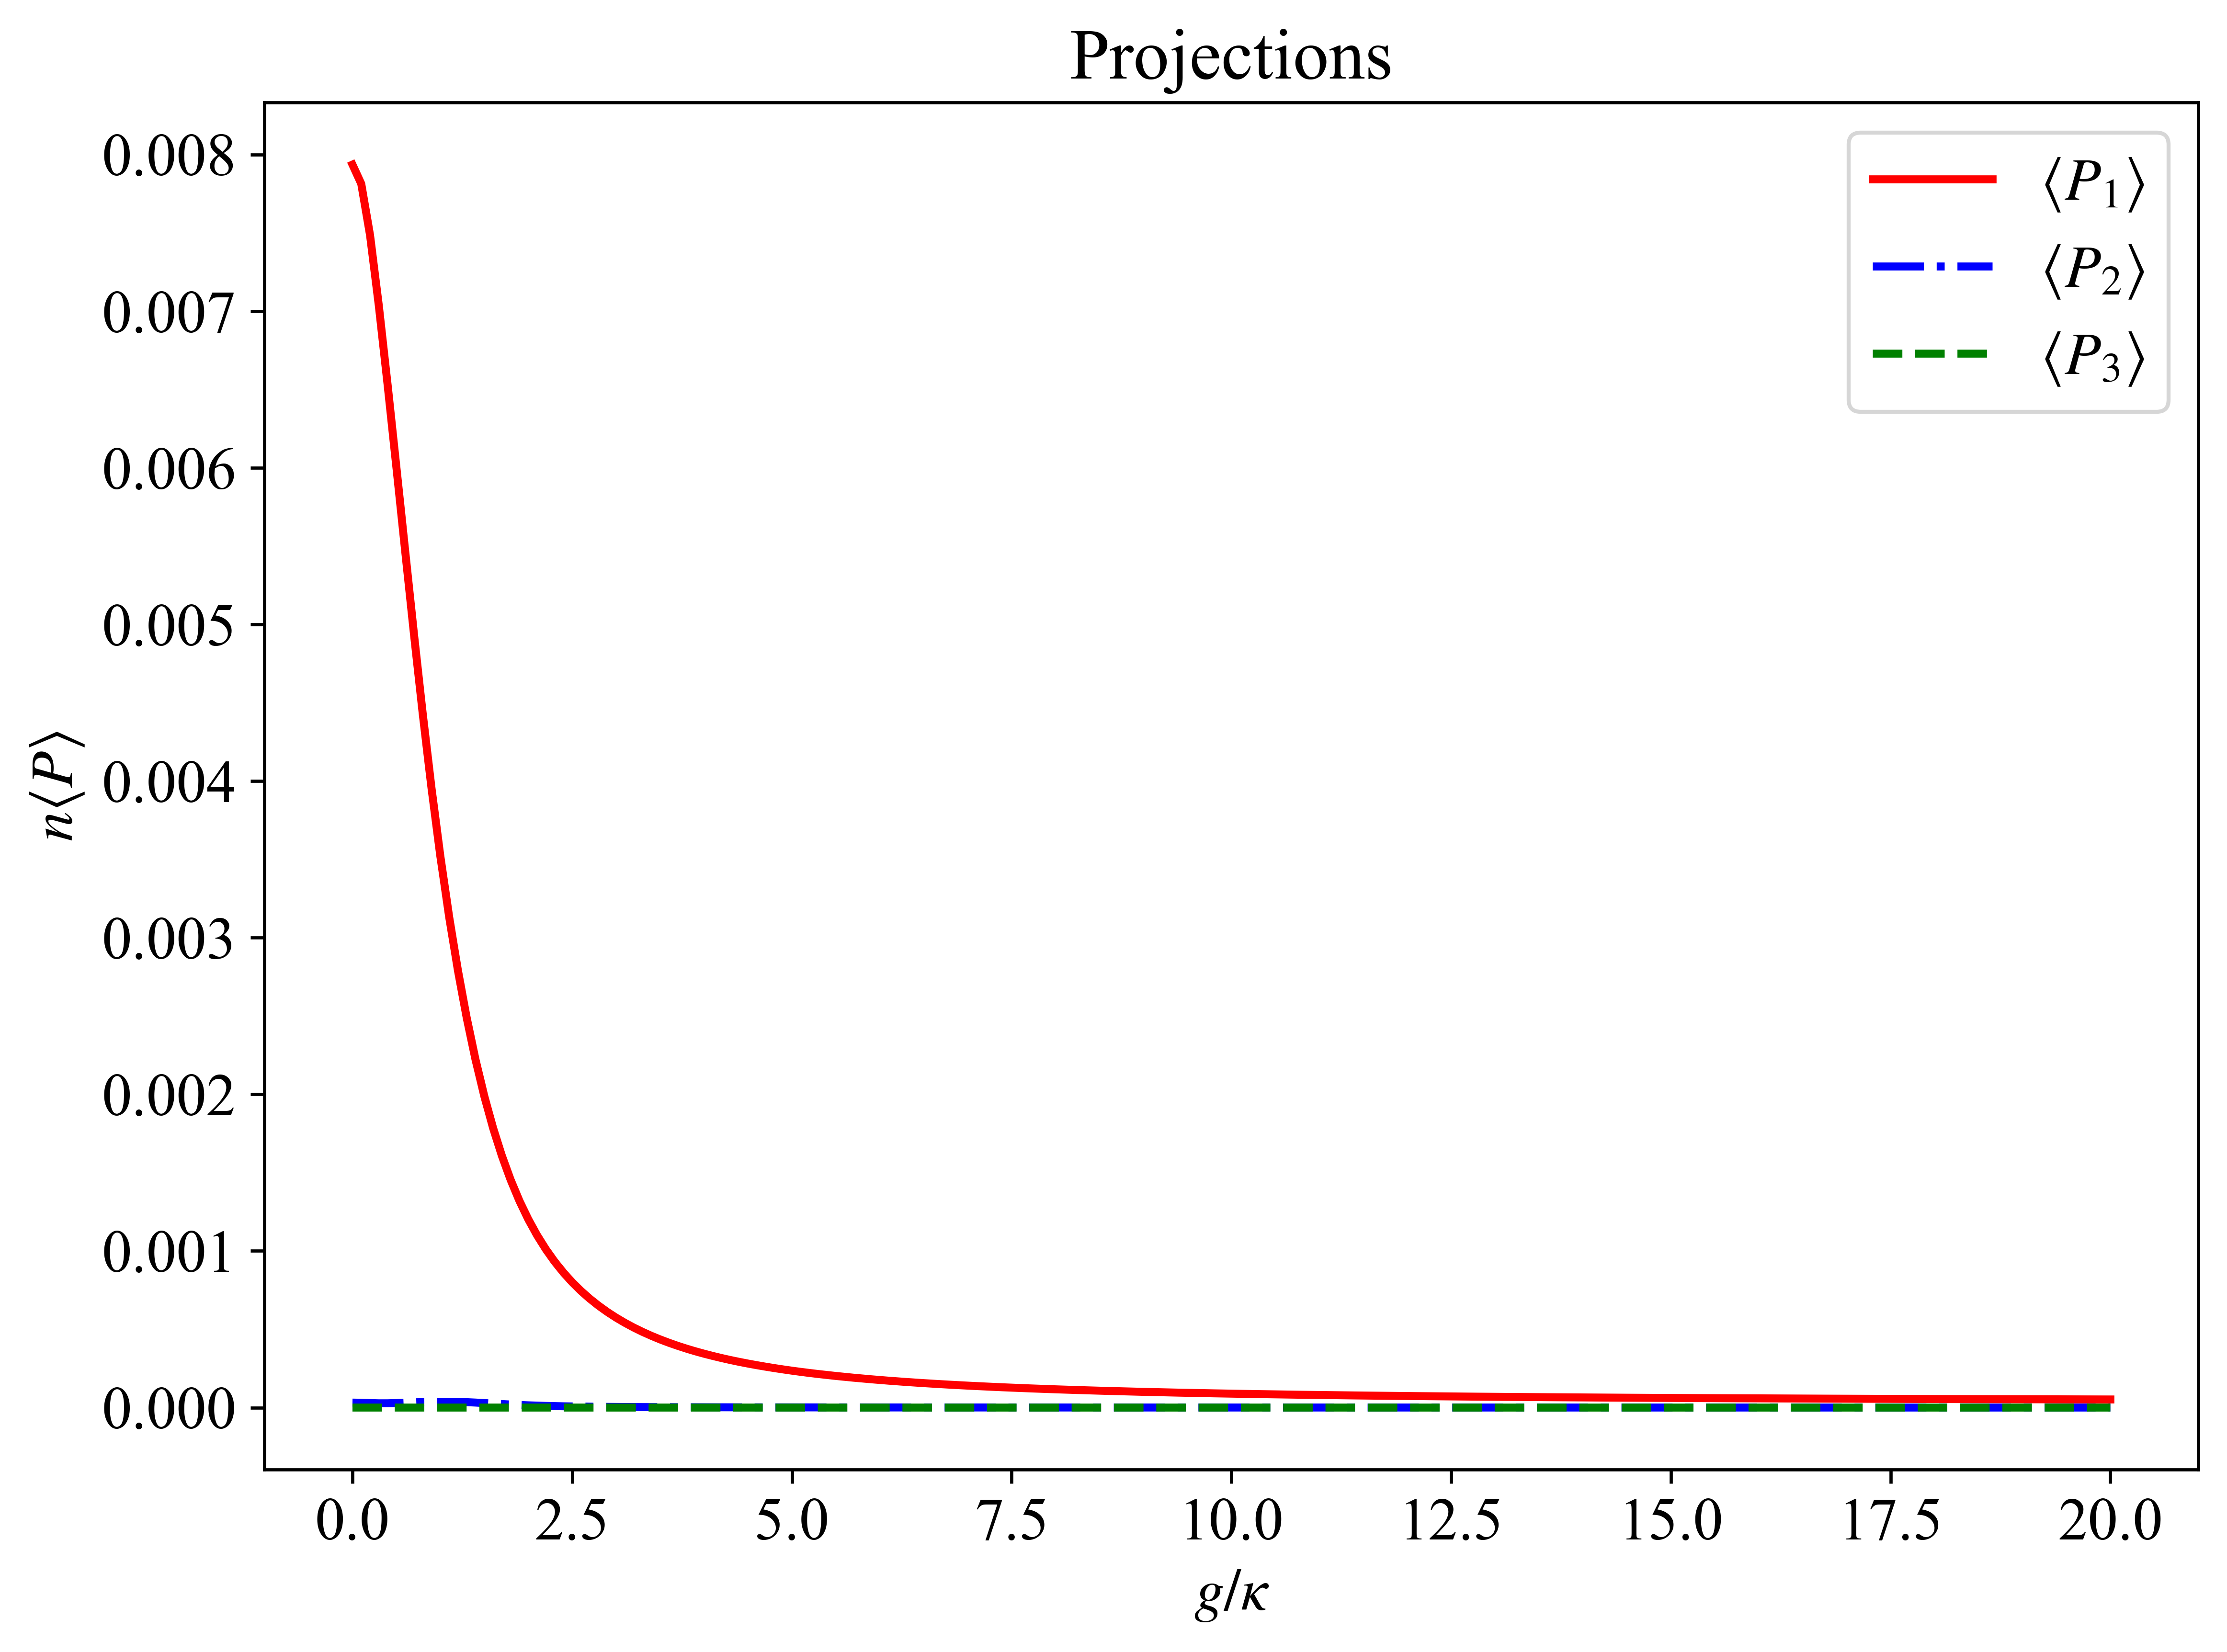

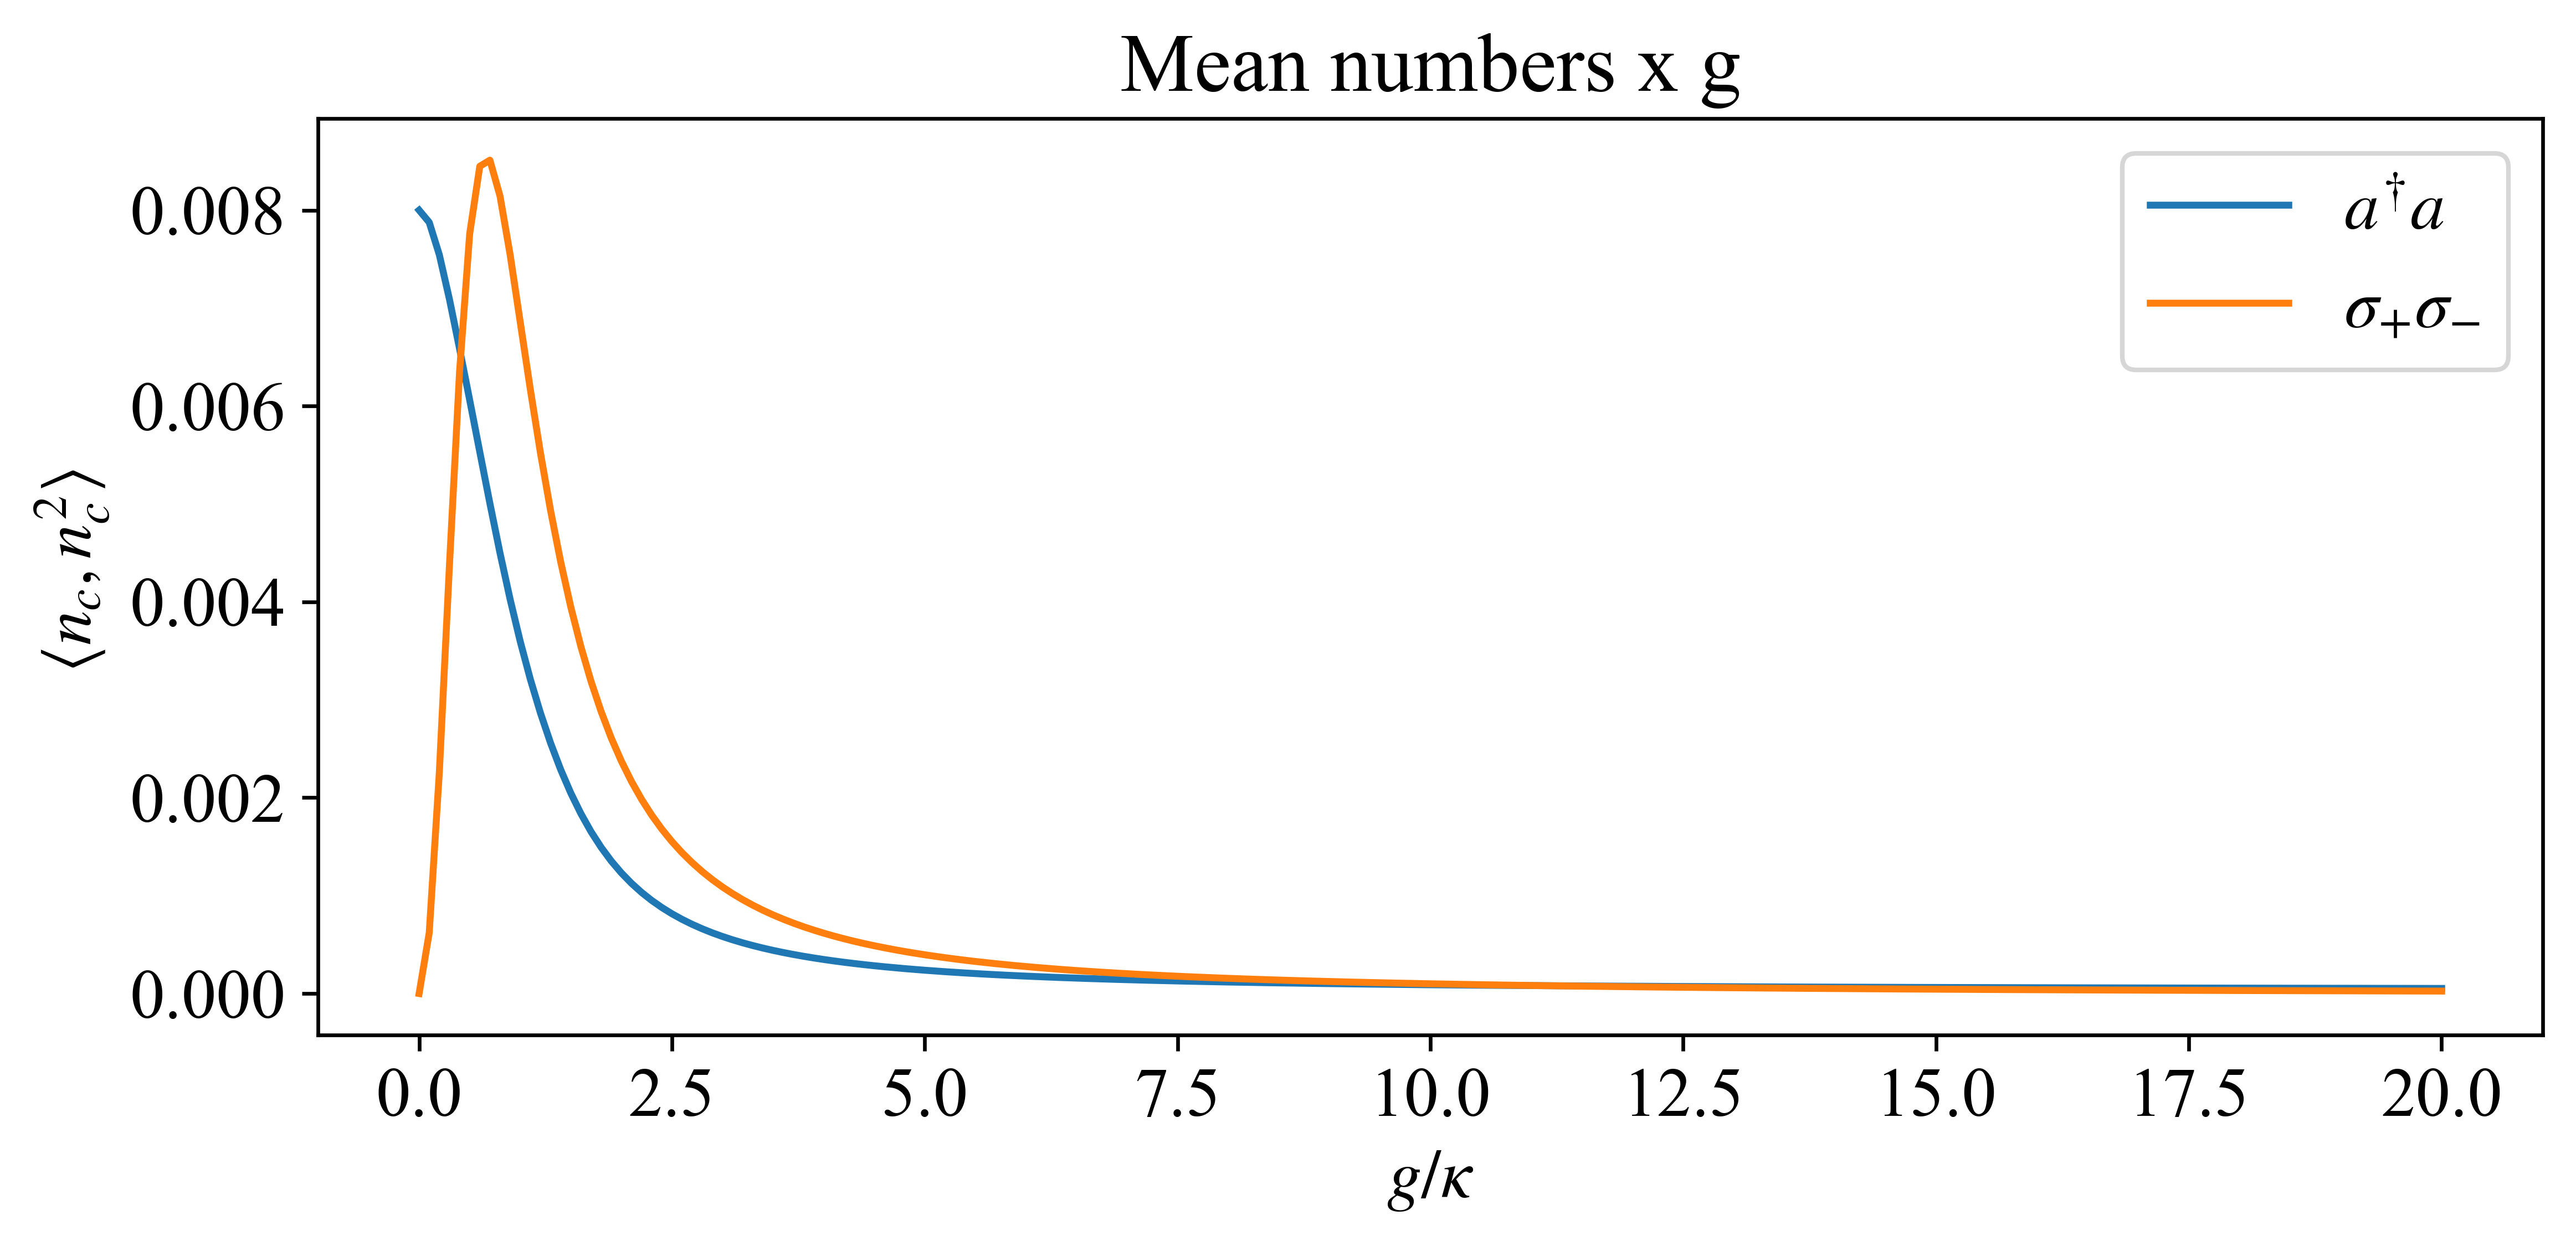

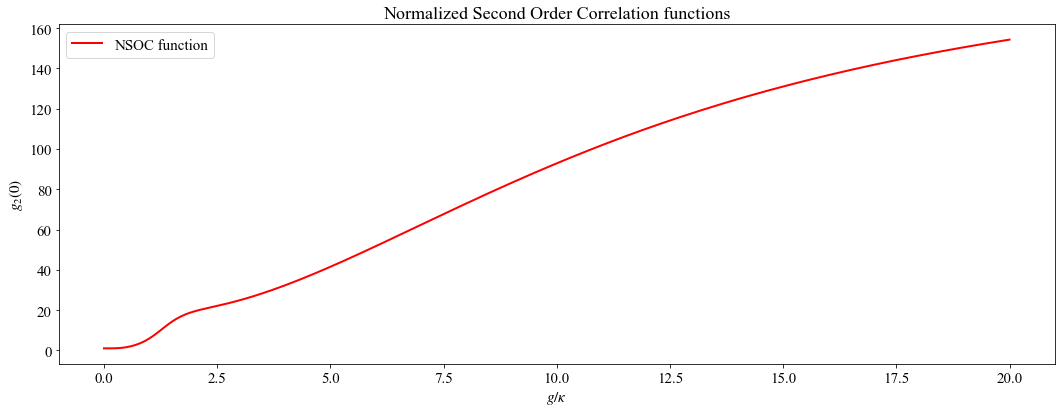

In [12]:
rc = {"font.family" : "serif",
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams.update({"font.size": "15",})
plt.rcParams["figure.figsize"] = [2*3.54,1.2*3.54]
plt.rcParams["figure.autolayout"] = True

#projections

fig, axes = plt.subplots(1, 1, dpi=600, figsize=(8, 6))

axes.plot(glist, p_1_list, label = r'$\langle P_{1} \rangle$', linestyle = "-", lw = 2, color = "red")
axes.plot(glist, p_2_list, label = r'$\langle P_{2} \rangle$', linestyle = "-.", lw = 2, color = "blue")
axes.plot(glist, p_3_list, label = r'$\langle P_{3} \rangle$', linestyle = "--", lw = 2, color = "green")

#axes.plot(glist, p_6_list, label = r'$\langle P_{6} \rangle$')
#axes.plot(glist, pt_list, label = "<Pt>")
axes.legend(loc=1)
axes.set_xlabel(r'$g/\kappa$')
axes.set_ylabel(r'$n \langle P \rangle$')
axes.set_title("Projections");

#fig.savefig('fockprojections_e1_lowgamma.png', format='png', dpi=600)

# Mean Numbers vs g

fig, axes = plt.subplots(1, 1,dpi=600, figsize=(8, 4))

axes.plot(glist, nc1_list, label = r'$a^{\dagger} a$')
#axes.plot(glist, nc2_list, label = r'$a^{\dagger} a^{\dagger} a a$')
axes.plot(glist, na_list, label = r'$\sigma_{+}\sigma_{-}$')
axes.legend(loc=0)
axes.set_xlabel(r'$g/\kappa$')
axes.set_ylabel(r' $\langle n_{c}, n_{c}^{2}\rangle$ ')
axes.set_title(r'Mean numbers x g');

# Second order correlations

fig, axes = plt.subplots(1, 1, figsize=(15, 6))

axes.plot(glist , g2_0_list, label = "NSOC function", color = 'red', lw = 2)

#axes.set(xlim = (0.05, 10), ylim = (0, 1.01))

axes.legend(loc=0)
axes.set_xlabel(r'$g/\kappa$')
axes.set_ylabel(r'$g_{2}(0)$')
axes.set_title("Normalized Second Order Correlation functions");

In [ ]:
list_rho